In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.svm import LinearSVC,SVC
from sklearn.neighbors import KNeighborsClassifier
import lightgbm as ltb
from sklearn.neural_network import MLPClassifier
from copy import deepcopy

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
# initial some global parameters
static_end = 6246044

# Import data

In [3]:
s011 = pd.read_csv('data/emg.csv', header = None)
label = pd.read_csv('data/grasp.csv', header = None)
grasprepetition = pd.read_csv('data/grasprepetition.csv', header = None)


s011_static = s011.iloc[0:static_end]
label_static = label.iloc[0:static_end]
grasprepetition_static = grasprepetition.iloc[0:static_end]

In [4]:
s011_static.info()
label_static.info()
grasprepetition_static.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6246044 entries, 0 to 6246043
Data columns (total 12 columns):
 #   Column  Dtype  
---  ------  -----  
 0   0       float64
 1   1       float64
 2   2       float64
 3   3       float64
 4   4       float64
 5   5       float64
 6   6       float64
 7   7       float64
 8   8       float64
 9   9       float64
 10  10      float64
 11  11      float64
dtypes: float64(12)
memory usage: 571.8 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6246044 entries, 0 to 6246043
Data columns (total 1 columns):
 #   Column  Dtype
---  ------  -----
 0   0       int64
dtypes: int64(1)
memory usage: 47.7 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6246044 entries, 0 to 6246043
Data columns (total 1 columns):
 #   Column  Dtype
---  ------  -----
 0   0       int64
dtypes: int64(1)
memory usage: 47.7 MB


# Plot signals and labels

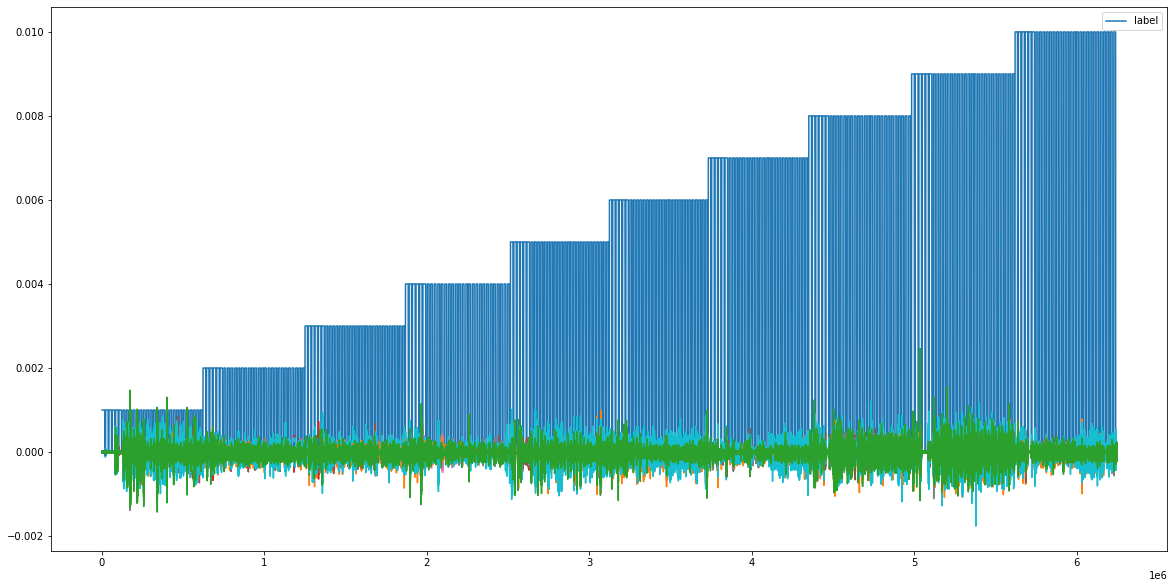

In [5]:
index = np.array(s011_static.index)
fig, ax = plt.subplots(1, figsize = (20,10))
line1, = ax.plot(label_static*0.001)
for i in tqdm(range(0,12)):
    ax.plot(index, s011_static[i])
    
line1.set_label('label')
ax.legend()
plt.show()

# Find training set and testing set

In [6]:
# get the grasprepetition [1,9] as raw training data, [10,12] as raw testing data
train_index = []
test_index = []
for i in tqdm(range(len(grasprepetition_static))):
    if grasprepetition_static.iloc[i,0] in [1,2,3,4,5,6,7,8,9]:
        train_index.append(i)
    if grasprepetition_static.iloc[i,0] in [10,11,12]:
        test_index.append(i)

In [7]:
trainx = s011_static.iloc[train_index].reset_index(drop=True)
trainy = label_static.iloc[train_index].reset_index(drop=True)

testx1 = s011_static.iloc[test_index].reset_index(drop=True)
testy1 = label_static.iloc[test_index].reset_index(drop=True)


In [8]:
trainx
trainy

,0,1,2,3,4,5,6,7,8,9,10,11
0,-0.000002,3.982600e-06,-1.449500e-06,7.566100e-07,-1.833000e-06,3.078100e-05,0.000013,-1.191000e-07,2.123900e-07,-5.811500e-06,-6.490600e-06,-0.000023
1,-0.000007,4.051200e-06,1.898300e-06,4.208100e-07,-1.156600e-07,3.329800e-05,0.000014,4.846100e-08,3.942600e-06,-2.553000e-06,-6.154800e-06,-0.000012
2,-0.000013,3.216600e-06,5.469300e-06,1.763500e-06,1.614600e-06,2.708800e-05,0.000010,2.164400e-07,6.897700e-06,8.051200e-06,-7.833200e-06,0.000002
3,-0.000008,-8.413400e-07,4.968800e-06,1.763400e-06,1.733900e-07,1.399600e-05,0.000007,2.169800e-07,9.069400e-06,1.112200e-05,-1.102200e-05,0.000008
4,0.000003,-5.438300e-06,-6.518100e-07,-8.299200e-08,2.327600e-07,4.764700e-06,0.000005,-1.177700e-07,1.090800e-05,8.570900e-06,-1.068600e-05,0.000010
...,...,...,...,...,...,...,...,...,...,...,...,...
1877571,0.000040,8.383300e-06,7.248900e-06,-3.805500e-06,1.925900e-06,1.487900e-06,0.000010,-1.525700e-07,-9.492200e-06,8.992600e-07,-5.020300e-07,0.000012
1877572,0.000036,1.308300e-05,1.144500e-05,-2.630600e-06,4.517300e-06,8.163300e-07,0.000009,-1.526200e-07,-1.758000e-05,8.993200e-07,-1.005700e-06,0.000008
1877573,0.000036,1.526500e-05,1.262100e-05,-1.287900e-06,7.207600e-06,4.804900e-07,0.000010,-1.526600e-07,-2.026400e-05,2.074400e-06,6.726500e-07,0.000003
1877574,0.000036,1.123700e-05,1.094200e-05,-2.809400e-07,8.732400e-06,-2.037400e-06,0.000004,-1.527000e-07,-2.579500e-05,1.738700e-06,2.854600e-06,-0.000003


,0
0,1
1,1
2,1
3,1
4,1
...,...
1877571,0
1877572,0
1877573,0
1877574,0


In [9]:
# a = 379
# trainx.iloc[a-379:a+1,0].std()
# trainx_aft_window.iloc[a-379,0]

In [10]:
# add overlapping window to training data
trainx_aft_window = deepcopy(trainx)
trainy_aft_window = deepcopy(trainy)

for i in tqdm(range(379,len(trainx))):
    for j in range(0,12):
        trainx_aft_window.iloc[i,j] = trainx.iloc[i-379:i+1,j].std()

trainx_aft_window = trainx_aft_window.iloc[379:len(trainx_aft_window),:]
trainy_aft_window = trainy_aft_window.iloc[379:len(trainy_aft_window),:]

In [11]:
trainx_aft_window = trainx_aft_window.reset_index(drop=True)
trainy_aft_window = trainy_aft_window.reset_index(drop=True)

In [12]:
trainx_aft_window
trainy_aft_window

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.000072,0.000037,0.000018,0.000006,0.000004,0.000005,0.000005,4.186619e-07,0.000058,0.000015,0.000005,0.000009
1,0.000072,0.000038,0.000018,0.000006,0.000004,0.000005,0.000005,4.186760e-07,0.000058,0.000015,0.000005,0.000009
2,0.000072,0.000038,0.000018,0.000006,0.000004,0.000005,0.000005,4.188020e-07,0.000058,0.000016,0.000005,0.000009
3,0.000072,0.000038,0.000019,0.000006,0.000004,0.000005,0.000005,4.190851e-07,0.000058,0.000016,0.000005,0.000009
4,0.000072,0.000038,0.000019,0.000006,0.000004,0.000005,0.000005,4.205121e-07,0.000059,0.000016,0.000005,0.000009
...,...,...,...,...,...,...,...,...,...,...,...,...
1877192,0.000021,0.000011,0.000006,0.000005,0.000004,0.000005,0.000004,2.989526e-07,0.000026,0.000006,0.000004,0.000007
1877193,0.000021,0.000011,0.000006,0.000005,0.000004,0.000005,0.000004,2.988449e-07,0.000026,0.000006,0.000004,0.000007
1877194,0.000021,0.000011,0.000006,0.000005,0.000004,0.000005,0.000004,2.982976e-07,0.000026,0.000006,0.000004,0.000007
1877195,0.000021,0.000011,0.000006,0.000005,0.000004,0.000005,0.000004,2.983116e-07,0.000026,0.000006,0.000004,0.000007


,0
0,1
1,1
2,1
3,1
4,1
...,...
1877192,0
1877193,0
1877194,0
1877195,0


In [13]:
testx1
testy1

,0,1,2,3,4,5,6,7,8,9,10,11
0,4.422500e-07,0.000015,1.884500e-06,1.999600e-06,0.000006,-5.078200e-07,-0.000003,7.264000e-08,-2.682200e-05,-4.465100e-06,-6.578300e-06,-9.314100e-05
1,-2.584100e-06,0.000013,2.345400e-06,3.006800e-06,0.000005,1.506500e-06,-0.000003,7.264500e-08,-2.019800e-05,-2.749900e-06,-4.641000e-06,-3.398000e-05
2,-1.013900e-05,0.000008,1.567800e-06,2.671300e-06,0.000008,1.171000e-06,-0.000001,7.265000e-08,-1.347400e-05,2.817300e-06,-5.374500e-07,-1.316900e-05
3,-1.509200e-05,0.000002,1.564100e-06,6.364100e-06,0.000016,-1.716100e-07,-0.000003,7.265500e-08,-5.344300e-06,4.848200e-06,1.146100e-06,-1.145500e-05
4,-1.217700e-05,0.000002,1.837100e-06,8.546300e-06,0.000025,4.999700e-07,-0.000003,-9.519000e-08,9.258100e-07,4.019100e-06,3.735000e-07,-9.980300e-06
...,...,...,...,...,...,...,...,...,...,...,...,...
594924,-5.910000e-07,-0.000004,1.366500e-06,5.956100e-06,0.000003,-5.487900e-07,0.000001,2.770800e-07,-2.553800e-06,8.448800e-06,1.188900e-06,1.107600e-06
594925,-2.437500e-06,-0.000007,-4.798700e-07,5.452500e-06,0.000001,-5.485500e-07,-0.000001,1.092200e-07,-2.889600e-06,6.098800e-06,1.389200e-08,4.363600e-07
594926,-8.648100e-06,-0.000009,-8.156400e-07,5.284500e-06,0.000004,1.130200e-06,-0.000002,2.770700e-07,-2.889700e-06,4.252400e-06,1.021000e-06,-3.424000e-06
594927,-1.167000e-05,-0.000007,-6.478600e-07,3.438100e-06,0.000005,2.305300e-06,-0.000002,-5.864100e-08,-4.064700e-06,3.918300e-07,5.175600e-07,-3.423800e-06


,0
0,1
1,1
2,1
3,1
4,1
...,...
594924,0
594925,0
594926,0
594927,0


In [14]:
# add overlapping window to testing data
testx1_aft_window = deepcopy(testx1)
testy1_aft_window = deepcopy(testy1)

for i in tqdm(range(379,len(testx1))):
    for j in range(0,12):
        testx1_aft_window.iloc[i,j] = testx1.iloc[i-379:i+1,j].std()

testx1_aft_window = testx1_aft_window.iloc[379:len(testx1_aft_window),:]
testy1_aft_window = testy1_aft_window.iloc[379:len(testy1_aft_window),:]

### plot training set

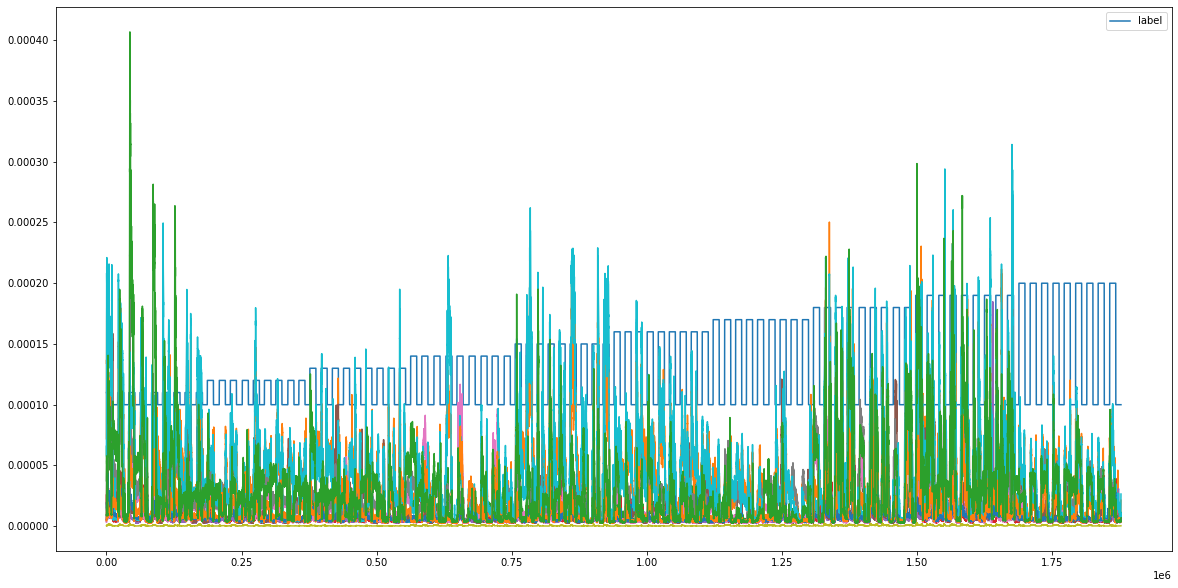

In [46]:
# trainx_aft_window = trainx_aft_window.reset_index(drop = True)
# trainy_aft_window = trainy_aft_window.reset_index(drop= True)

index = np.array(trainx_aft_window.index)
fig, ax = plt.subplots(1, figsize = (20,10))
line1, = ax.plot(trainy_aft_window*0.00001+0.0001)
for i in tqdm(range(0,12)):
    ax.plot(index, trainx_aft_window[i])
    
line1.set_label('label')
ax.legend()
plt.show()

### plot testing set #1

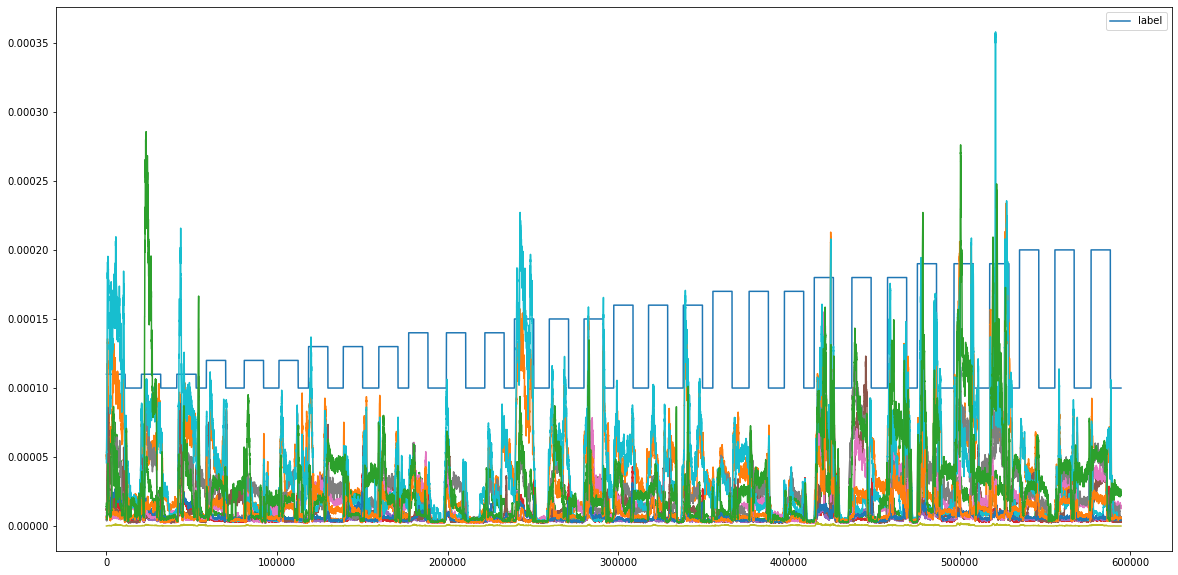

In [47]:
testx1_aft_window = testx1_aft_window.reset_index(drop = True)
testy1_aft_window = testy1_aft_window.reset_index(drop= True)

index = np.array(testx1_aft_window.index)
fig, ax = plt.subplots(1, figsize = (20,10))
line1, = ax.plot(testy1_aft_window*0.00001+0.0001)
for i in tqdm(range(0,12)):
    ax.plot(index, testx1_aft_window[i])
    
line1.set_label('label')
ax.legend()
plt.show()

### find the testing set #2

In [17]:
# find the fisrt 200ms which is 385 data point

# find the ten start point
# ten_start_point is for the testing data set #2
counter = 0
label_number = [1,2,3,4,5,6,7,8,9,10]
checked_label = []
ten_start_point = []
for i in label_number:
    for j in tqdm(range(0, len(testy1_aft_window))):
        if testy1_aft_window.iloc[j,0] == i:
            if i not in checked_label:
                counter += 1
                checked_label.append(i)
                ten_start_point.append(j)
        if counter == 10:
            break
            
# find the ten new end point
# ten_end_point is for the testing data set #2
last = 1
ten_end_point = []
label_number = [1,2,3,4,5,6,7,8,9,10]
for j in label_number:
    last = j
    counter = 0
    for i in tqdm(range(ten_start_point[j-1], len(testy1_aft_window))):
        if i == len(testy1_aft_window)-1:
            ten_end_point.append(i)
        current = testy1_aft_window.iloc[i,0]
        if last == current:
            last = current
        else:
            last = current
            counter += 1
        if counter == 1:
            ten_end_point.append(i)
            break
            
testx2_aft_window = testx1_aft_window.iloc[ten_start_point[0]:ten_start_point[0]+385, :]
testx2_aft_window = testx2_aft_window.append(testx1_aft_window.iloc[ten_end_point[0]:ten_end_point[0]+385, :])

for i in range(1,10):
#     if i == 9:
#         testx2_aft_window = testx2_aft_window.append(testx1_aft_window.iloc[ten_start_point[i]:ten_start_point[i]+385, :])
#         testx2_aft_window = testx2_aft_window.append(testx1_aft_window.iloc[ten_end_point[i]:220557, :])
#         break
    testx2_aft_window = testx2_aft_window.append(testx1_aft_window.iloc[ten_start_point[i]:ten_start_point[i]+385, :])
    testx2_aft_window = testx2_aft_window.append(testx1_aft_window.iloc[ten_end_point[i]:ten_end_point[i]+385, :])

testy2_aft_window = testy1_aft_window.iloc[ten_start_point[0]:ten_start_point[0]+385, :]
testy2_aft_window = testy2_aft_window.append(testy1_aft_window.iloc[ten_end_point[0]:ten_end_point[0]+385, :])

for i in range(1,10):
#     if i == 9:
#         testy2_aft_window = testy2_aft_window.append(testy1_aft_window.iloc[ten_start_point[i]:ten_start_point[i]+385, :])
#         testy2_aft_window = testy2_aft_window.append(testy1_aft_window.iloc[ten_end_point[i]:220557, :])
#         break
    testy2_aft_window = testy2_aft_window.append(testy1_aft_window.iloc[ten_start_point[i]:ten_start_point[i]+385, :])
    testy2_aft_window = testy2_aft_window.append(testy1_aft_window.iloc[ten_end_point[i]:ten_end_point[i]+385, :])

### plot testing set #2

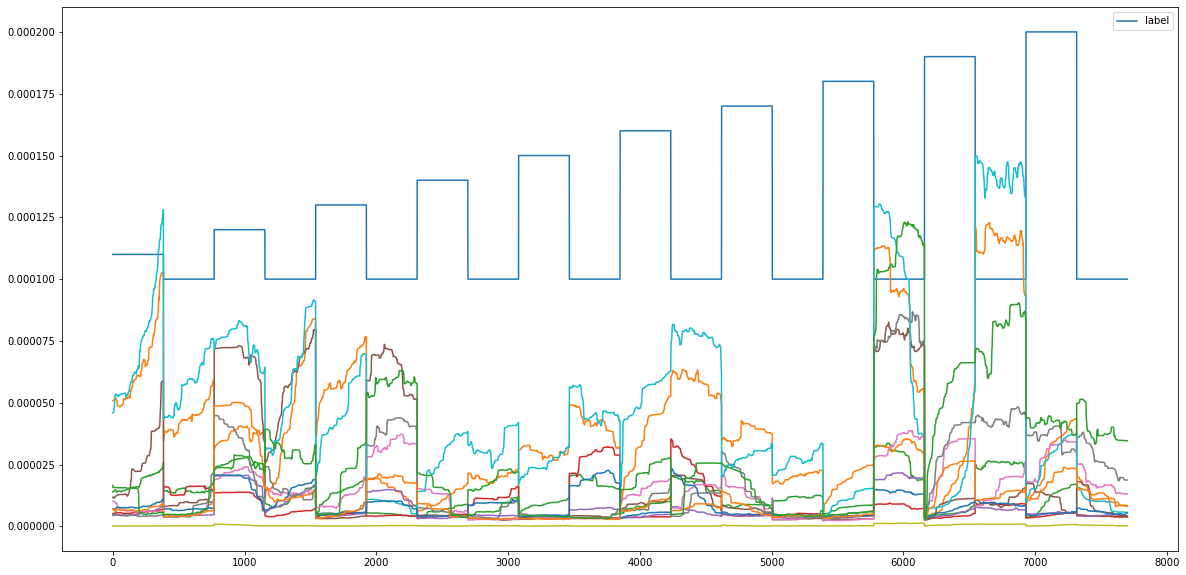

In [48]:
testx2_aft_window = testx2_aft_window.reset_index(drop = True)
testy2_aft_window = testy2_aft_window.reset_index(drop= True)

index = np.array(testx2_aft_window.index)
fig, ax = plt.subplots(1, figsize = (20,10))
line1, = ax.plot(testy2_aft_window*0.00001+0.0001)
for i in tqdm(range(0,12)):
    ax.plot(index, testx2_aft_window[i])
    
line1.set_label('label')
ax.legend()
plt.show()

## SVM model

In [19]:
# svm_model = SVC()
# svm_model.fit(trainx,trainy)

# expected1 = testy1.values.flatten()
# predicted1 = svm_model.predict(testx1)
# expected2 = testy2.values.flatten()
# predicted2 = svm_model.predict(testx2)

### calculate the accuracy

In [20]:
# counter = 0
# for i in range(0, len(expected1)):
#     if expected1[i] == predicted1[i]:
#         counter += 1

# accuracy1 = counter/len(expected1)

# counter = 0
# for i in range(0, len(expected2)):
#     if expected2[i] == predicted2[i]:
#         counter += 1

# accuracy2 = counter/len(expected2)

### plot testing results

In [21]:
# index = np.array(testy1.index)
# fig, ax = plt.subplots(1, figsize = (20,10))
# line1, = ax.plot(predicted1*0.0001+0.001)
# line2, = ax.plot(expected1*0.0001+0.001)
    
# line1.set_label('predicted')
# line2.set_label('expected')
# ax.legend()
# plt.show()

# index = np.array(testy2.index)
# fig, ax = plt.subplots(1, figsize = (20,10))
# line1, = ax.plot(predicted2*0.0001+0.001)
# line2, = ax.plot(expected22*0.0001+0.001)
    
# line1.set_label('predicted')
# line2.set_label('expected')
# ax.legend()
# plt.show()

## KNN model

In [22]:
knn_model = KNeighborsClassifier(n_neighbors = 5)

In [23]:
knn_model.fit(trainx_aft_window,trainy_aft_window)

<ipython-input-23-152fd8550894>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn_model.fit(trainx_aft_window,trainy_aft_window)


KNeighborsClassifier()

In [24]:
expected1 = testy1_aft_window.values.flatten()
predicted1 = knn_model.predict(testx1_aft_window)

In [25]:
expected2 = testy2_aft_window.values.flatten()
predicted2 = knn_model.predict(testx2_aft_window)

### calculate the accuracy

In [26]:
counter = 0
for i in range(0, len(expected1)):
    if expected1[i] == predicted1[i]:
        counter += 1

accuracy1 = counter/len(expected1)

counter = 0
for i in range(0, len(expected2)):
    if expected2[i] == predicted2[i]:
        counter += 1

accuracy2 = counter/len(expected2)

In [27]:
accuracy1
accuracy2

0.6520376755529392

0.45

### plot testing results

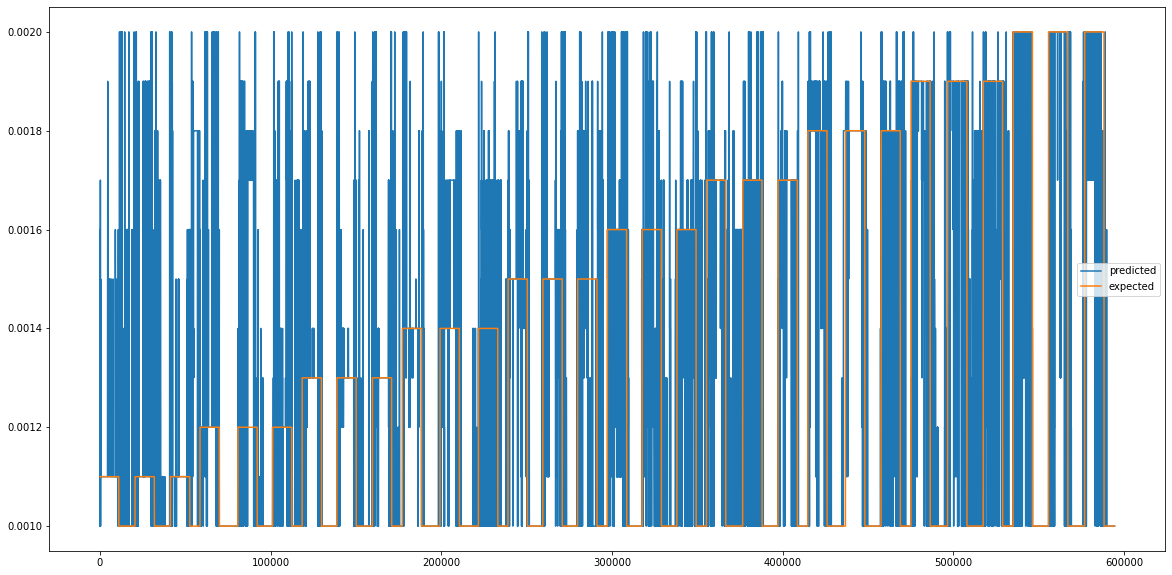

In [28]:
index = np.array(testy1.index)
fig, ax = plt.subplots(1, figsize = (20,10))
line1, = ax.plot(predicted1*0.0001+0.001)
line2, = ax.plot(expected1*0.0001+0.001)
    
line1.set_label('predicted')
line2.set_label('expected')
ax.legend()
plt.show()

## lightGBM model

In [29]:
lightGBM_model = ltb.LGBMClassifier()

In [30]:
lightGBM_model.fit(trainx_aft_window,trainy_aft_window)

/Users/shuowang/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


LGBMClassifier()

In [31]:
expected1 = testy1_aft_window.values.flatten()
predicted1 = lightGBM_model.predict(testx1_aft_window)

In [32]:
expected2 = testy2_aft_window.values.flatten()
predicted2 = lightGBM_model.predict(testx2_aft_window)

### calculate the accuracy

In [33]:
counter = 0
for i in range(0, len(expected1)):
    if expected1[i] == predicted1[i]:
        counter += 1

accuracy1 = counter/len(expected1)

counter = 0
for i in range(0, len(expected2)):
    if expected2[i] == predicted2[i]:
        counter += 1

accuracy2 = counter/len(expected2)

In [34]:
accuracy1
accuracy2

0.7119603061138676

0.3757142857142857

### plot testing results

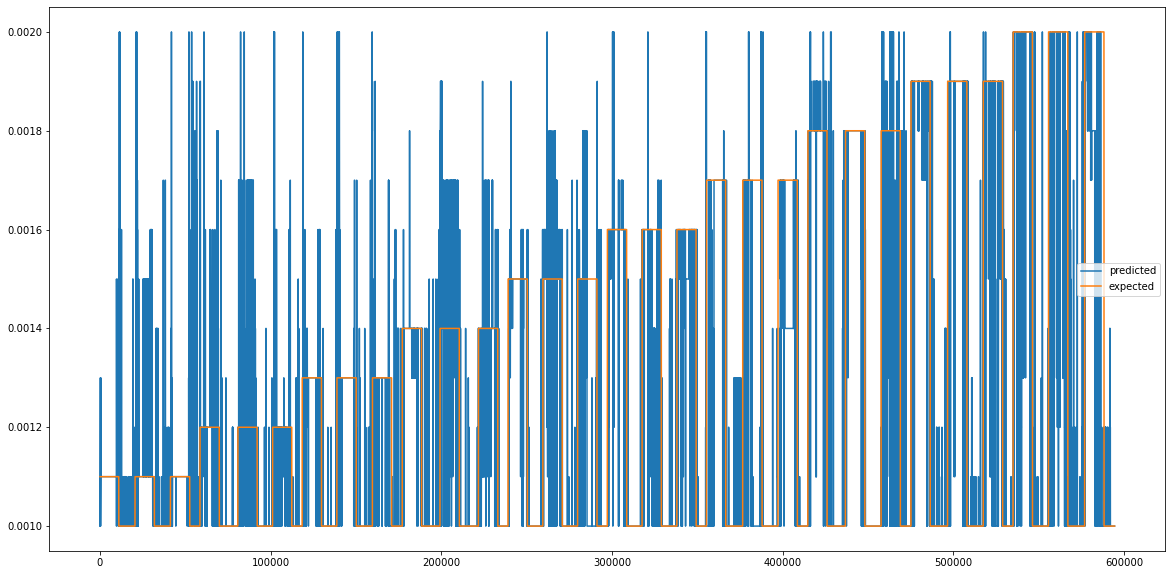

In [35]:
index = np.array(testy1.index)
fig, ax = plt.subplots(1, figsize = (20,10))
line1, = ax.plot(predicted1*0.0001+0.001)
line2, = ax.plot(expected1*0.0001+0.001)
    
line1.set_label('predicted')
line2.set_label('expected')
ax.legend()
plt.show()

## MLP model

In [36]:
# MLP_model = MLPClassifier(random_state=1, max_iter=300).fit(trainx,trainy)

In [37]:
# expected1 = testy1.values.flatten()
# predicted1 = MLP_model.predict(testx1)

### calculate the accuracy

In [38]:
# counter = 0
# for i in range(0, len(expected1)):
#     if expected1[i] == predicted1[i]:
#         counter += 1

# accuracy1 = counter/len(expected1)

In [39]:
# accuracy1

### plot testing results

In [40]:
# index = np.array(testy1.index)
# fig, ax = plt.subplots(1, figsize = (20,10))
# line1, = ax.plot(predicted1*0.0001+0.001)
# line2, = ax.plot(expected1*0.0001+0.001)
    
# line1.set_label('predicted')
# line2.set_label('expected')
# ax.legend()
# plt.show()

In [49]:
trainx.to_csv('traintestdata/raw/trainx.csv', header=False, index=False)
trainy.to_csv('traintestdata/raw/trainy.csv', header=False, index=False)

In [50]:
testx1.to_csv('traintestdata/raw/testx1.csv', header=False, index=False)
testy1.to_csv('traintestdata/raw/testy1.csv', header=False, index=False)

In [51]:
trainx_aft_window.to_csv('traintestdata/std/trainx_std.csv', header=False, index=False)
trainy_aft_window.to_csv('traintestdata/std/trainy_std.csv', header=False, index=False)
testx1_aft_window.to_csv('traintestdata/std/testx1_std.csv', header=False, index=False)
testy1_aft_window.to_csv('traintestdata/std/testy1_std.csv', header=False, index=False)
testx2_aft_window.to_csv('traintestdata/std/testx2_std.csv', header=False, index=False)
testy2_aft_window.to_csv('traintestdata/std/testy2_std.csv', header=False, index=False)